## Suavización Exponencial de Segundo Orden con Actualización del Factor de Descuento

### Introducción Teórica del Modelo Trigg-Leach (TL)

El modelo Trigg-Leach (TL) es una técnica adaptativa de suavización exponencial diseñada para mejorar la capacidad de seguimiento de cambios dinámicos en las series temporales. A diferencia de la suavización exponencial tradicional, que usa un factor de descuento fijo (λ), el modelo TL ajusta dinámicamente este factor en función de los errores de predicción. Esta adaptabilidad permite que el modelo responda a cambios en la tendencia de los datos, ajustando el parámetro de suavización en tiempo real.

En nuestra investigación, aplicada al análisis de series temporales de potencia eléctrica, el modelo TL permite actualizar el factor de suavización en función de las fluctuaciones observadas. El ajuste se basa en la relación entre la señal de error (Qt) y la desviación promedio del error (Dt), lo que genera un nuevo valor de λ para cada observación. De esta forma, el modelo TL está diseñado para responder mejor a variaciones imprevistas en la serie temporal, lo que lo hace útil en contextos donde las tendencias pueden cambiar abruptamente.

El funcionamiento del modelo TL se describe mediante los siguientes conceptos
- **Error de suavización:** $ e_t = y_t - \tilde{y}_{t-1} $ ,  que representa la diferencia entre el valor real y el suavizado previo.
- **Señal de seguimiento:** $ Q_t = \delta e_t + (1 - \delta) Q_{t-1} $,  que acumula los errores de predicción para ajustar el suavizado.
- **Actualización del factor de descuento:** $ \lambda_t = \left| \frac{Q_t}{D_t} \right| $, , donde $ D_t $ es la desviación promedio de los errores.
- **Nuevo valor suavizado:** $ \tilde{y}_t = \lambda_t y_t + (1 - \lambda_t) \tilde{y}_{t-1} $ , que utiliza el factor ajustado para calcular el valor suavizado actualizado.

El objetivo de este enfoque es mejorar la capacidad del modelo para capturar los patrones dinámicos de los datos de potencia eléctrica, particularmente en los conjuntos de validación y prueba, donde es importante predecir con precisión futuras fluctuaciones.



In [7]:
# Importar las librerías necesarias
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt


# Ruta a la carpeta donde se encuentran los archivos de entrenamiento
train_folder = '/Users/josejavier-yenifer/Documents/Serie de Tiempo/Bono 1/train'

# Nombres de los archivos CSV
train_files = ['ex_1.csv', 'ex_9.csv', 'ex_20.csv', 'ex_21.csv', 'ex_23.csv', 'ex_24.csv']

# Cargar los archivos CSV en variables con prefijo 'df_' y nombre del archivo (sin .csv)
dfs = []
for file in train_files:
    file_name = file.split('.')[0]  # Eliminar la extensión .csv
    file_path = os.path.join(train_folder, file)
    
    # Crear una variable dinámica con el nombre df_<nombre_archivo>
    globals()[f"df_{file_name}"] = pd.read_csv(file_path)

    # Guardar el DataFrame para mostrar luego
    dfs.append((file_name, globals()[f"df_{file_name}"]))


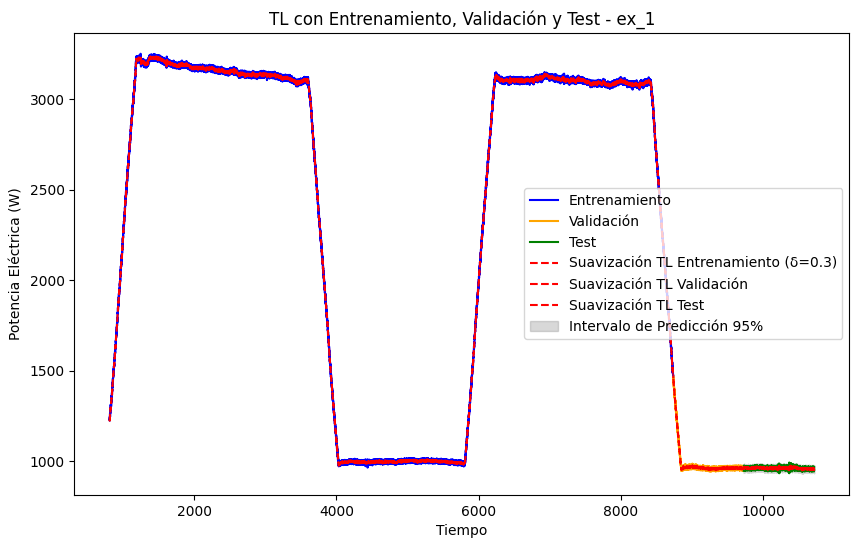

/var/folders/pc/g1c35bc91zbfqvk3gwrrc_5c0000gn/T/ipykernel_59922/1794983588.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)


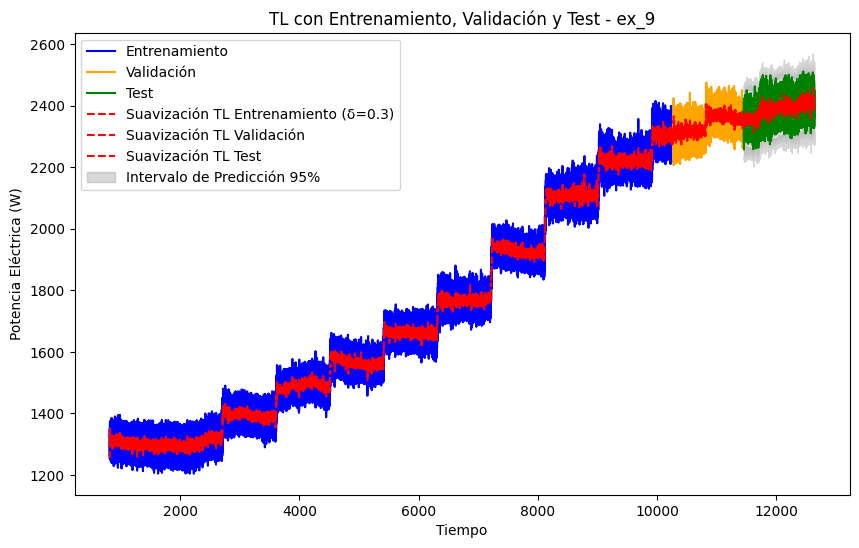

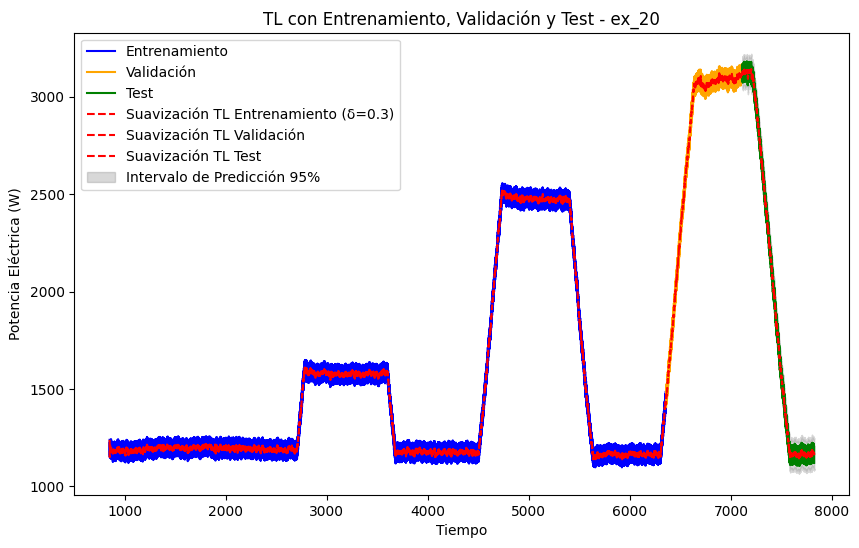

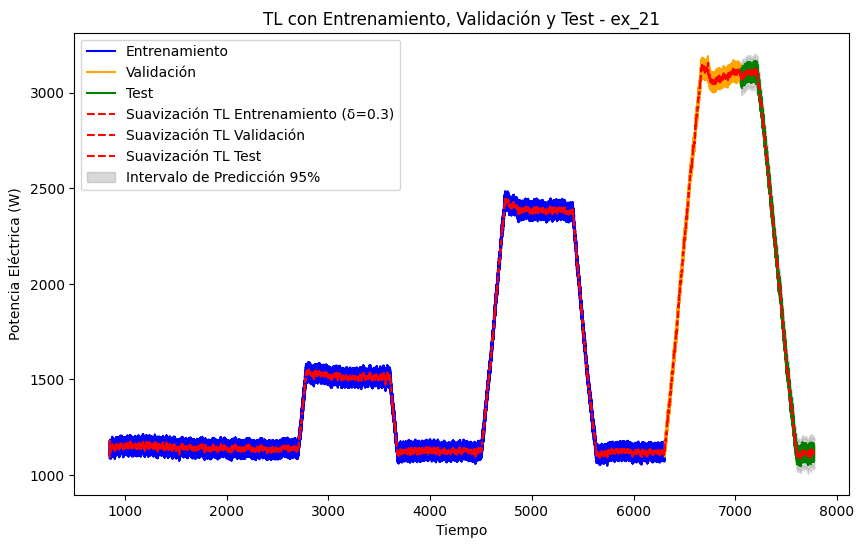

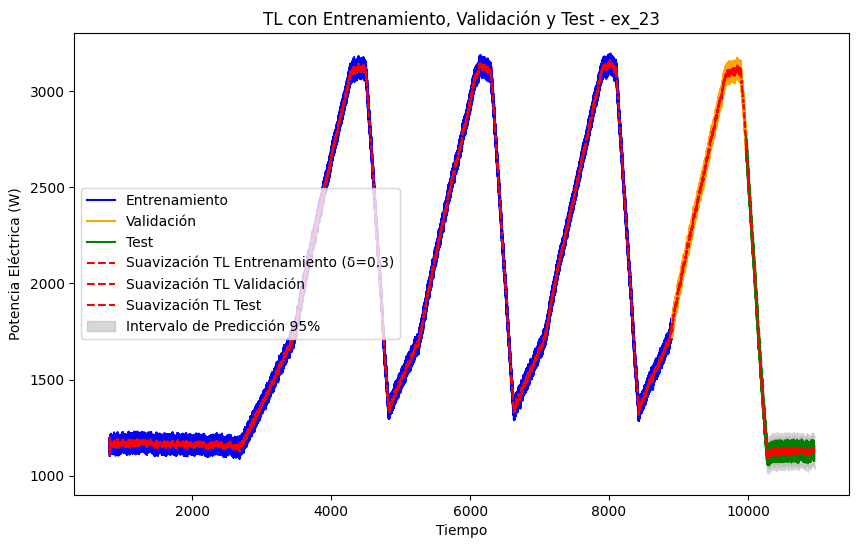

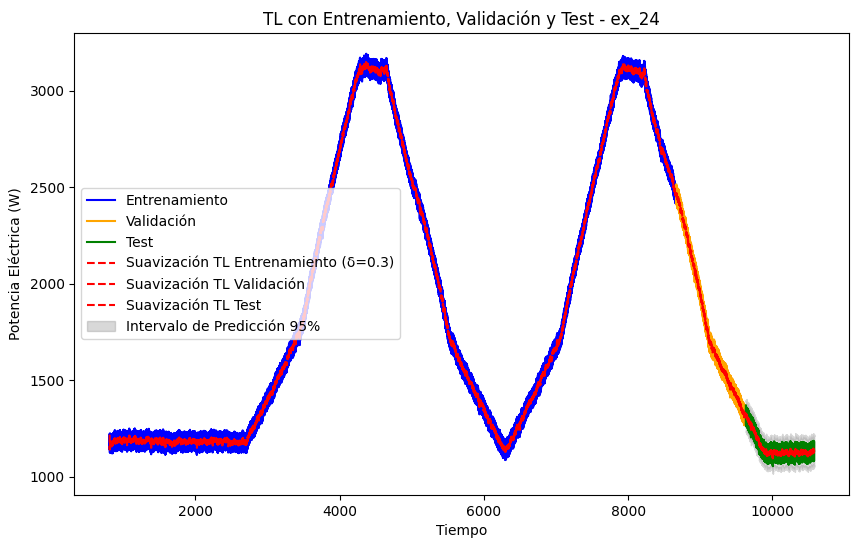

In [8]:

# Función de suavización Trigg-Leach con actualización de factor de descuento
def tlsmooth(y, delta_, y_tilde_start=None, lambda_start=1):
    T = len(y)
    
    # Inicialización de variables
    Qt = np.zeros(T)
    Dt = np.zeros(T)
    y_tilde = np.zeros(T)
    lambd = np.zeros(T)
    err = np.zeros(T)
    
    lambd[0] = lambda_start
    if y_tilde_start is None:
        y_tilde[0] = y[0]
    else:
        y_tilde[0] = y_tilde_start
    
    # Actualización iterativa del suavizado
    for i in range(1, T):
        err[i] = y[i] - y_tilde[i-1]  # Error de predicción
        Qt[i] = delta_ * err[i] + (1 - delta_) * Qt[i-1]  # Media suavizada del error
        Dt[i] = delta_ * abs(err[i]) + (1 - delta_) * Dt[i-1]  # Media suavizada del error absoluto
        lambd[i] = abs(Qt[i] / Dt[i])  # Actualización del factor de descuento
        y_tilde[i] = lambd[i] * y[i] + (1 - lambd[i]) * y_tilde[i-1]  # Actualización de la serie suavizada
    
    return np.column_stack((y_tilde, lambd, err, Qt, Dt))

# Función para calcular las métricas de precisión
def measacc_fs(y_true, y_pred):
    T = len(y_true)
    prederr = y_true - y_pred
    SSE = sum(prederr**2)
    MAPE = 100 * sum(abs(prederr / y_true)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr**2) / T
    return {"SSE": SSE, "MAPE": MAPE, "MAD": MAD, "MSD": MSD}

# Función para calcular solo el MAE (MAD)
def calculate_mae(y_true, y_pred):
    MAE = sum(abs(y_true - y_pred)) / len(y_true)
    return MAE

# Parámetro delta (tasa de actualización del factor de descuento)
delta_ = 0.3

# Lista de DataFrames y nombres para iterar
dataframes = [df_ex_1, df_ex_9, df_ex_20, df_ex_21, df_ex_23, df_ex_24]
names = ['ex_1', 'ex_9', 'ex_20', 'ex_21', 'ex_23', 'ex_24']

# División en entrenamiento, validación y test
train_size = 0.8  # 80% para entrenamiento
val_size = 0.1    # 10% para validación
test_size = 0.1   # 10% para test

# Crear un DataFrame para almacenar todas las métricas
metrics_df = pd.DataFrame(columns=['Experimento', 'SSE_Train', 'MAPE_Train', 'MAD_Train', 'MSD_Train',
                                   'SSE_Val', 'MAPE_Val', 'MAD_Val', 'MSD_Val', 'MAE_Test'])

# Aplicar suavización Trigg-Leach a cada serie de tiempo
for df, name in zip(dataframes, names):
    # Definir la longitud de cada conjunto
    n = len(df)
    train_end = int(train_size * n)
    val_end = train_end + int(val_size * n)
    
    # Dividir en conjuntos de entrenamiento, validación y test
    train_data = df['el_power'][:train_end]
    val_data = df['el_power'][train_end:val_end]
    test_data = df['el_power'][val_end:]
    
    # Aplicar la suavización en los datos de entrenamiento
    smooth_train = tlsmooth(train_data.values, delta_)[:, 0]
    
    # Suavización para el conjunto de validación usando el último valor suavizado del entrenamiento
    smooth_val = tlsmooth(np.concatenate([train_data.values, val_data.values]), delta_)[:, 0][train_end:val_end]
    
    # Suavización para el conjunto de test usando el último valor suavizado del conjunto de validación
    smooth_test = tlsmooth(np.concatenate([train_data.values, val_data.values, test_data.values]), delta_)[:, 0][val_end:]
    
    # Graficar la serie original con tres colores para los conjuntos de datos
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'][:train_end], df['el_power'][:train_end], color='blue', label='Entrenamiento')
    plt.plot(df['time'][train_end:val_end], df['el_power'][train_end:val_end], color='orange', label='Validación')
    plt.plot(df['time'][val_end:], df['el_power'][val_end:], color='green', label='Test')
    
    # Graficar la suavización en los tres conjuntos
    plt.plot(df['time'][:train_end], smooth_train, color='red', linestyle='--', label=f'Suavización TL Entrenamiento (δ={delta_})')
    plt.plot(df['time'][train_end:val_end], smooth_val, color='red', linestyle='--', label='Suavización TL Validación')
    plt.plot(df['time'][val_end:], smooth_test, color='red', linestyle='--', label='Suavización TL Test')

    # Graficar intervalos de predicción para el conjunto de test
    test_std = np.std(test_data.values - smooth_test)  # Desviación estándar del error de predicción en test
    plt.fill_between(df['time'][val_end:], smooth_test - 1.96 * test_std, smooth_test + 1.96 * test_std, 
                     color='gray', alpha=0.3, label='Intervalo de Predicción 95%')

    # Configuración del gráfico
    plt.title(f'TL con Entrenamiento, Validación y Test - {name}')
    plt.xlabel('Tiempo')
    plt.ylabel('Potencia Eléctrica (W)')
    plt.legend()
    plt.show()

    # Calcular las métricas de precisión en el conjunto de entrenamiento
    metrics_train = measacc_fs(train_data.values, smooth_train)
    
    # Calcular las métricas de precisión en el conjunto de validación
    metrics_val = measacc_fs(val_data.values, smooth_val)
    
    # Calcular solo el MAE (MAD) en el conjunto de test
    mae_test = calculate_mae(test_data.values, smooth_test)
    
    # Crear un DataFrame temporal con las métricas del experimento actual
    temp_df = pd.DataFrame({
        'Experimento': [name],
        'SSE_Train': [metrics_train['SSE']], 'MAPE_Train': [metrics_train['MAPE']],
        'MAD_Train': [metrics_train['MAD']], 'MSD_Train': [metrics_train['MSD']],
        'SSE_Val': [metrics_val['SSE']], 'MAPE_Val': [metrics_val['MAPE']],
        'MAD_Val': [metrics_val['MAD']], 'MSD_Val': [metrics_val['MSD']],
        'MAE_Test': [mae_test]
    })
    
    # Usar pd.concat() para agregar las filas al DataFrame de métricas
    metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)





la suavización exponencial de Trigg-Leach (TL) muestra una mejora en la adaptabilidad del modelo al incorporar un factor de descuento variable que ajusta el modelo según los cambios en la serie temporal. Este enfoque permite al modelo captar más rápidamente los cambios repentinos en los datos, lo que se refleja en una mejor predicción de las variaciones más abruptas, como se observó en los resultados visuales de los experimentos.

- **En las series de tiempo más constantes (ej. `ex_1`)**, el modelo TL sigue de manera eficiente la tendencia, con predicciones bastante cercanas a la realidad, tanto en entrenamiento como en validación. Los errores en el conjunto de prueba son bajos, lo que sugiere que la técnica de TL es eficaz.

- **En las series con más ruido o crecimiento no lineal (ej. `ex_9`)**, el modelo TL presenta un ajuste superior en comparación con los modelos de suavización exponencial simple o doble. Las predicciones de validación y prueba muestran una adaptación más precisa, lo que resalta la capacidad del método para ajustarse a cambios abruptos.




In [9]:
# Mostrar el DataFrame de métricas final
metrics_df

,Experimento,SSE_Train,MAPE_Train,MAD_Train,MSD_Train,SSE_Val,MAPE_Val,MAD_Val,MSD_Val,MAE_Test
0,ex_1,7.313637e+05,0.417549,8.709003,92.157725,6.682634e+04,0.765080,7.506017,67.365264,8.308473
1,ex_9,2.593278e+07,3.143547,51.467033,2742.757959,3.555410e+06,2.286343,53.478990,3010.507814,56.175652
2,ex_20,8.356480e+06,2.949032,39.876726,1608.252596,1.069125e+06,1.523835,40.351120,1647.341607,39.868212
3,ex_21,8.116796e+06,3.024083,39.278268,1562.123875,1.075183e+06,1.685779,40.429325,1656.676246,39.979105
4,ex_23,1.205469e+07,2.409503,40.258496,1640.093608,1.523550e+06,1.601321,40.469464,1659.640197,40.175903
5,ex_24,1.181921e+07,2.423520,40.228710,1637.463548,1.477161e+06,2.333233,40.227366,1637.651227,40.387245




En comparación con los modelos de suavización exponencial simple y doble, el modelo Trigg-Leach (TL) mostró un desempeño ligeramente inferior en términos de error.

1. **SSE y MAD:** Los errores cuadráticos (SSE) y absolutos (MAD) en el modelo TL fueron más altos en la mayoría de los experimentos, lo que sugiere que TL no se ajusta tan bien a las series temporales en comparación con los otros modelos.

2. **MAPE:** Aunque en algunos casos como en `ex_1`, el MAPE fue bajo, en general los errores porcentuales fueron mayores, indicando que TL tiene dificultades para capturar cambios pequeños de manera precisa.

3. **MAE en el Test:** El error absoluto medio (MAE) en el conjunto de test fue consistentemente más alto, lo que implica que el modelo TL tiene una menor capacidad de predicción que los modelos de suavización simple y doble.


